<a href="https://colab.research.google.com/github/raiadi96/SiameseNNPytorch/blob/main/SiameseNNAlphabetSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
dataset  = dsets.Omniglot(root = './data/',
                            transform = transforms.ToTensor(),
                            download = True
                            )


Files already downloaded and verified


In [ ]:
len(dataset)

19280

In [ ]:
import random
from PIL import Image
import PIL.ImageOps   
import numpy as np
class SiameseNetworkDataset(Dataset):

  def __init__(self, imageFolderDataset, transform = None, should_invert = True ):
    self.imageFolderDataset = imageFolderDataset
    self.transform = transform
    self.should_invert = should_invert
    
  
  def __getitem__(self, index):
    img0_tuple = random.choice(self.imageFolderDataset.imgs)
    should_get_same_class = random.randint(0,1) 
    if should_get_same_class:
        while True:
            img1_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img0_tuple[1]==img1_tuple[1]:
                break
    else:
        while True:                
            img1_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img0_tuple[1] !=img1_tuple[1]:
                break

    img0 = Image.open(img0_tuple[0])
    img1 = Image.open(img1_tuple[0])
    img0 = img0.convert("L")
    img1 = img1.convert("L")
    
    if self.should_invert:
        img0 = PIL.ImageOps.invert(img0)
        img1 = PIL.ImageOps.invert(img1)

    if self.transform is not None:
        img0 = self.transform(img0)
        img1 = self.transform(img1)
    
    return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
  
  def __len__(self):
    return len(self.imageFolderDataset.imgs)
    

In [ ]:
dataset_path = dsets.ImageFolder('/content/data/omniglot-py/images_background/Sanskrit')
siamese_dataset = SiameseNetworkDataset(imageFolderDataset= dataset_path,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

torch.Size([16, 1, 100, 100])
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]


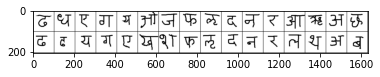

In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=16)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
print(example_batch[1].shape)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.imshow(torchvision.utils.make_grid(concatenated, nrow = 16).permute(1,2,0))
print(example_batch[2].numpy())

In [ ]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.cnn1 = nn.Sequential(
        nn.ReflectionPad2d(2),
        nn.Conv2d(1, 16, kernel_size= 3),
        nn.ReLU(inplace= True),
        nn.BatchNorm2d(16),

        nn.ReflectionPad2d(2),
        nn.Conv2d(16, 24, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(24),


        nn.ReflectionPad2d(2),
        nn.Conv2d(24, 8, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(8),
    )

    self.fc1 = nn.Sequential(
      nn.Linear(8*106*106, 500),
      nn.ReLU(inplace=True),

      nn.Linear(500, 500),
      nn.ReLU(inplace=True),

      nn.Linear(500, 1)
      )
    
  def forward_once(self, x):
    output = self.cnn1(x)
    output = output.view(output.size()[0], -1)
    output = self.fc1(output)
    return output

  def forward(self, input1, input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = []
iteration_number = 0
number_epoch = 10

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

Epoch number 0
 Current loss 1.8698444366455078

Epoch number 1
 Current loss 1.1490583419799805

Epoch number 2
 Current loss 1.523409128189087

Epoch number 3
 Current loss 2.6054208278656006

Epoch number 4
 Current loss 1.2533636093139648

Epoch number 5
 Current loss 1.6979278326034546

Epoch number 6
 Current loss 1.435837745666504

Epoch number 7
 Current loss 1.3110668659210205

Epoch number 8
 Current loss 0.9930664300918579

Epoch number 9
 Current loss 0.7981126308441162



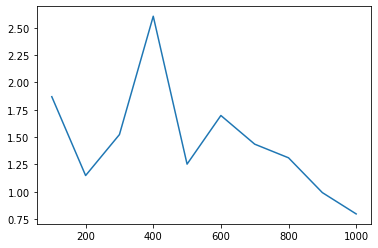

In [ ]:
for epoch in range(0, number_epoch):
  for i, data in enumerate(vis_dataloader,0):
    img0, img1, label = data
    img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
    optimizer.zero_grad()
    output1, output2 = net(img0, img1)
    loss = criterion(output1, output2, label)
    loss.backward()
    optimizer.step()
    if i %100 == 0 :
      print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
      iteration_number +=100
      counter.append(iteration_number)
      loss_history.append(loss.item())
show_plot(counter,loss_history)

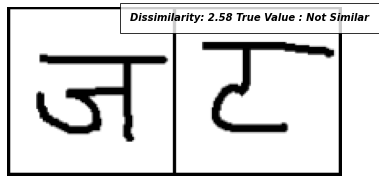

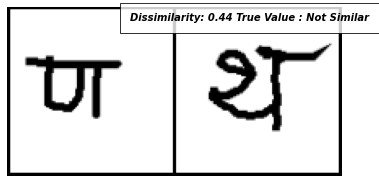

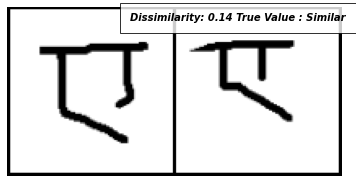

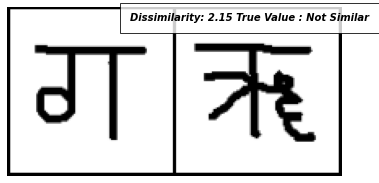

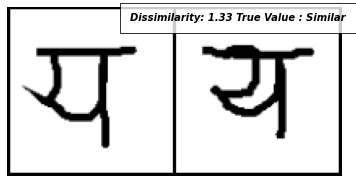

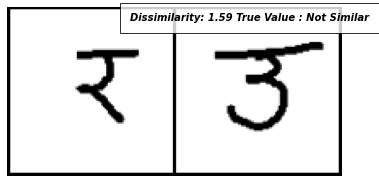

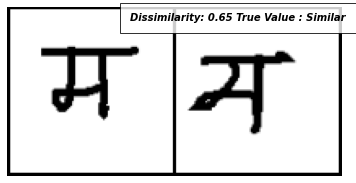

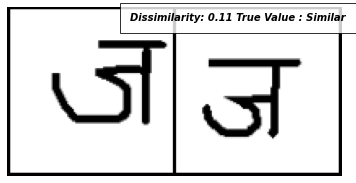

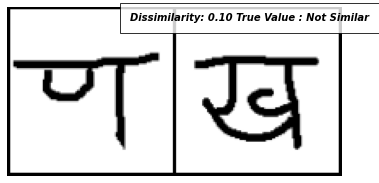

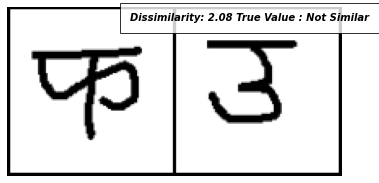

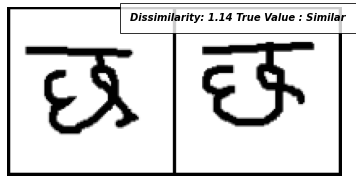

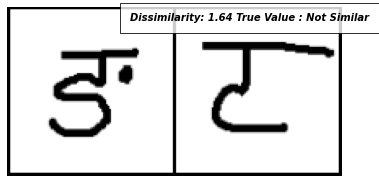

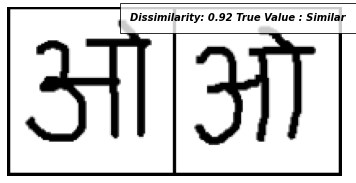

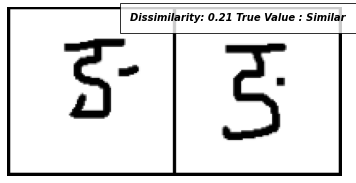

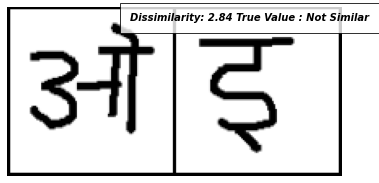

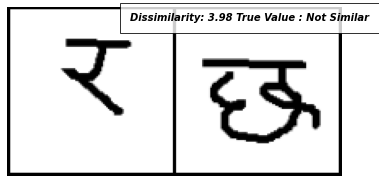

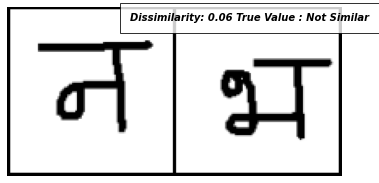

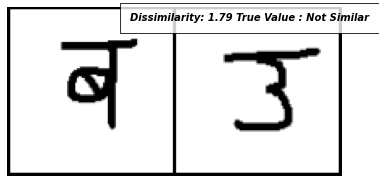

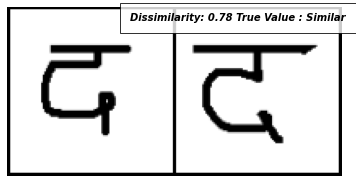

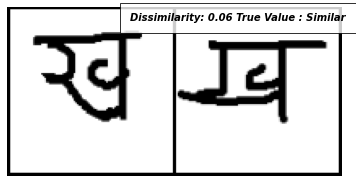

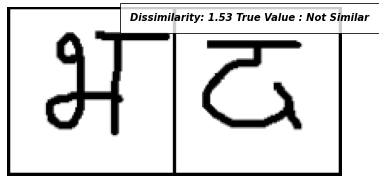

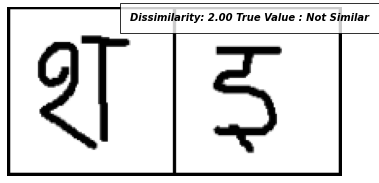

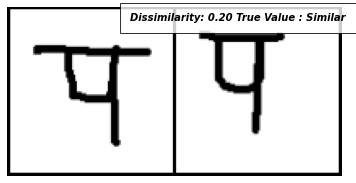

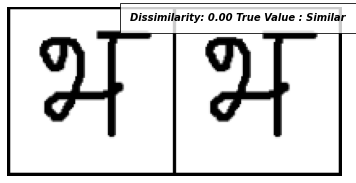

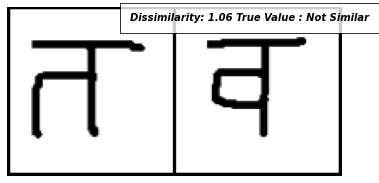

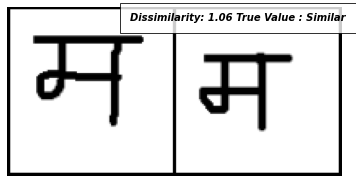

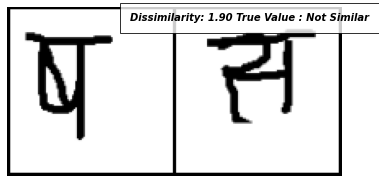

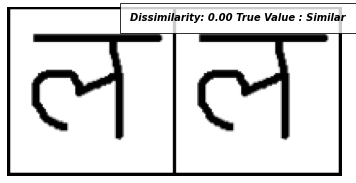

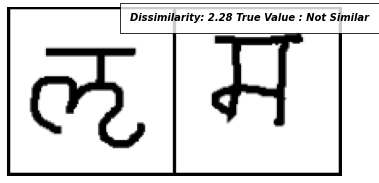

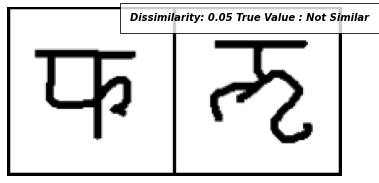

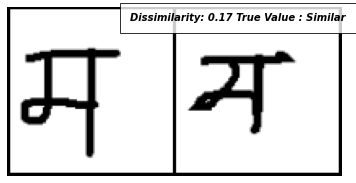

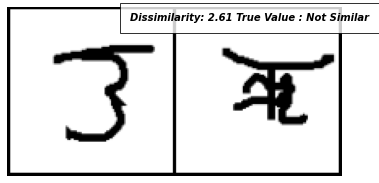

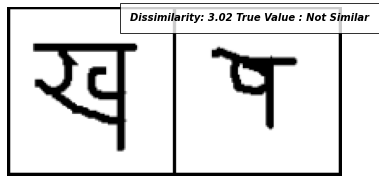

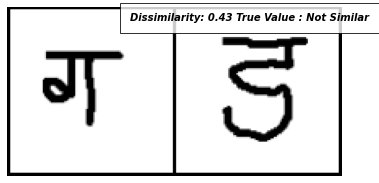

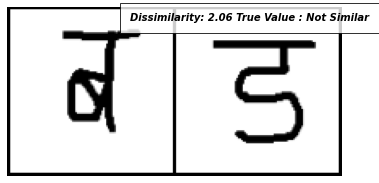

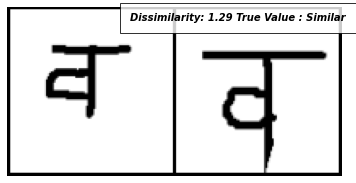

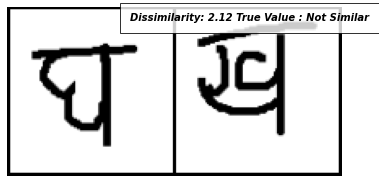

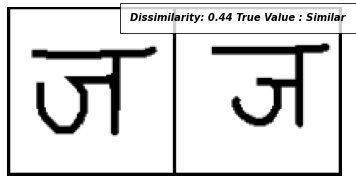

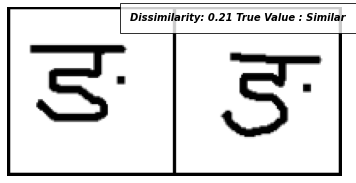

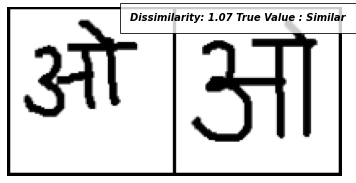

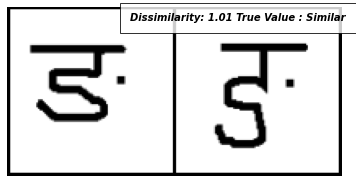

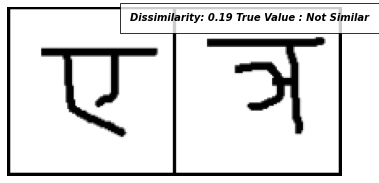

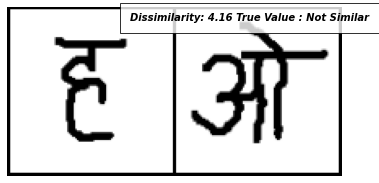

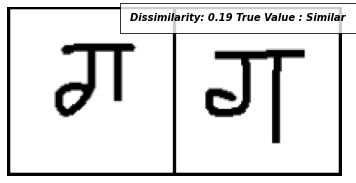

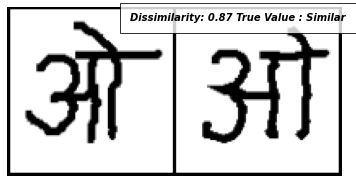

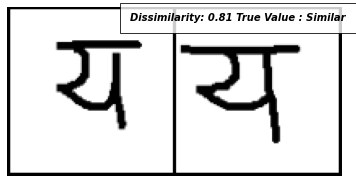

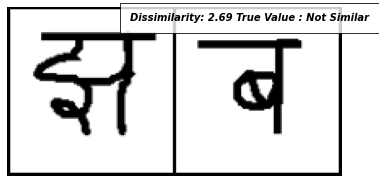

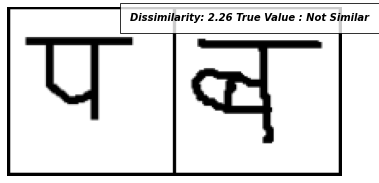

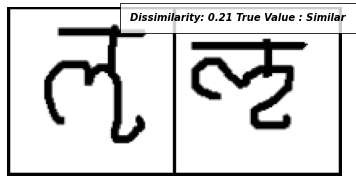

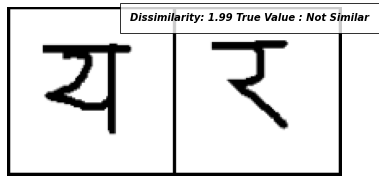

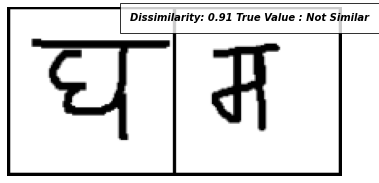

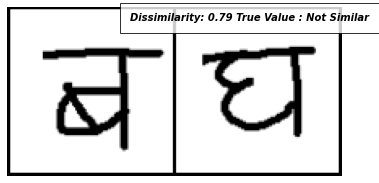

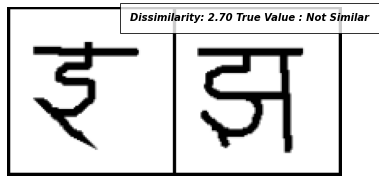

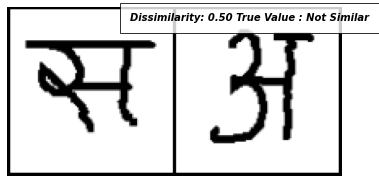

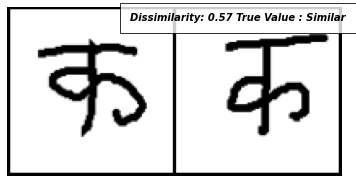

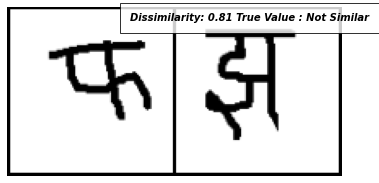

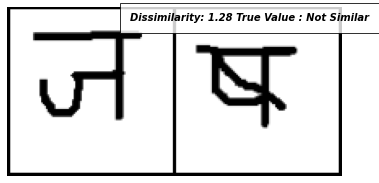

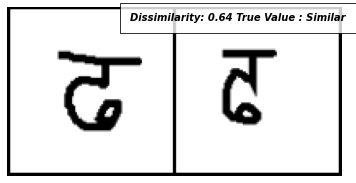

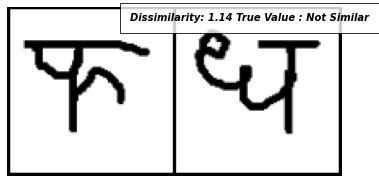

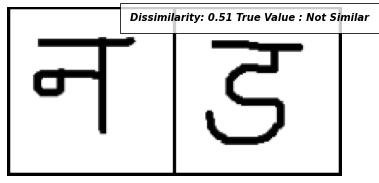

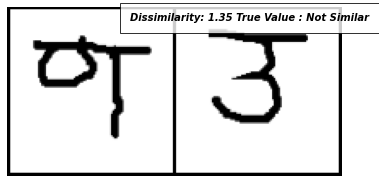

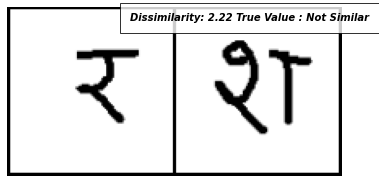

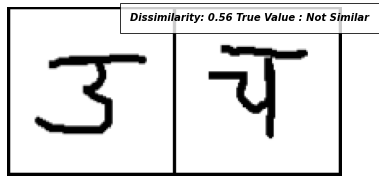

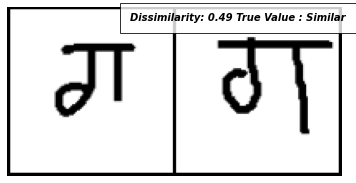

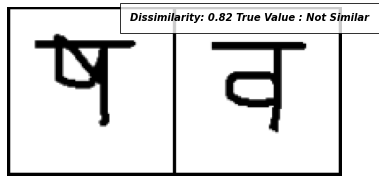

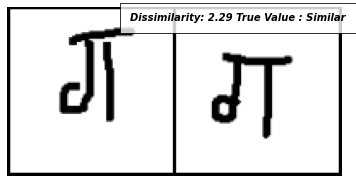

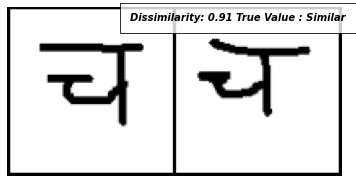

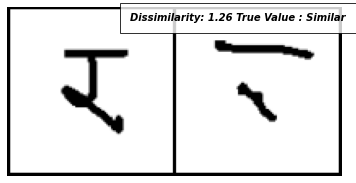

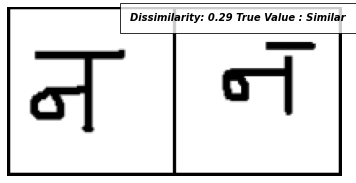

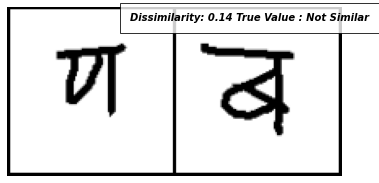

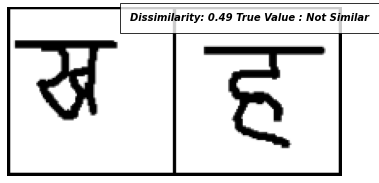

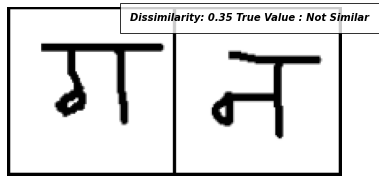

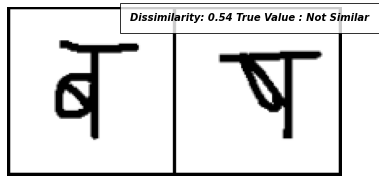

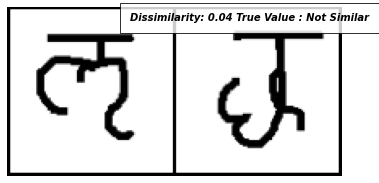

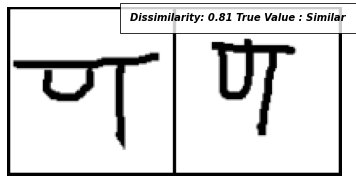

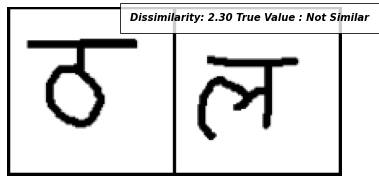

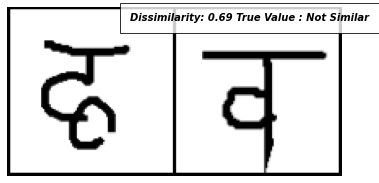

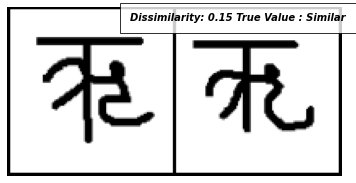

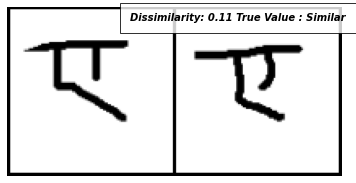

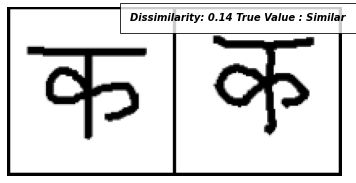

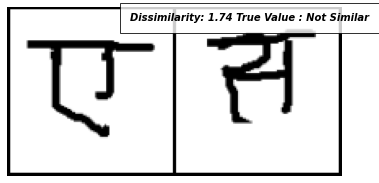

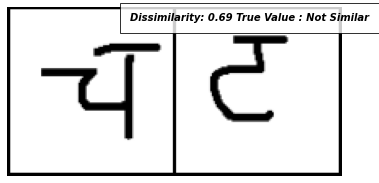

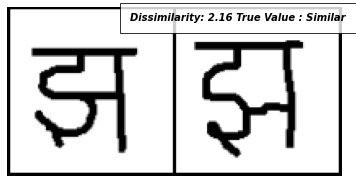

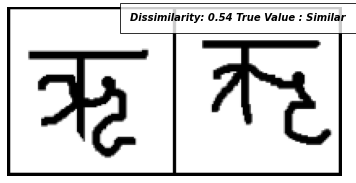

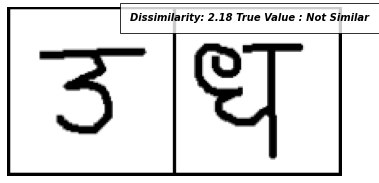

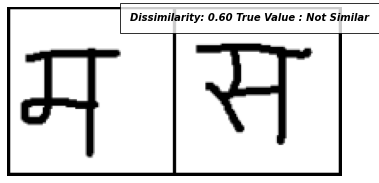

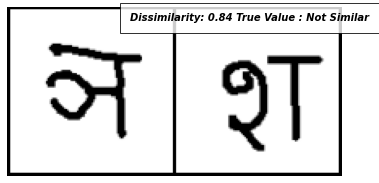

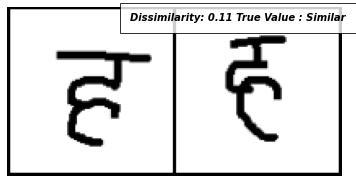

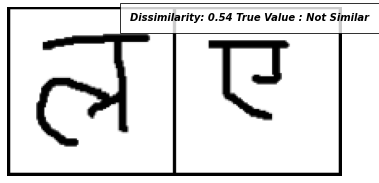

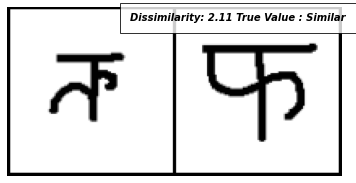

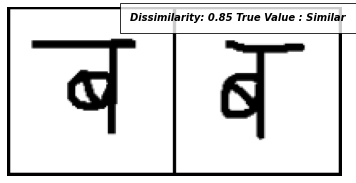

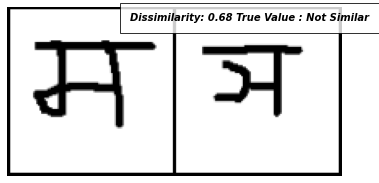

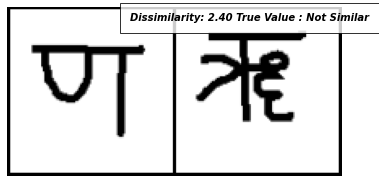

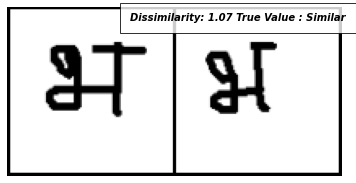

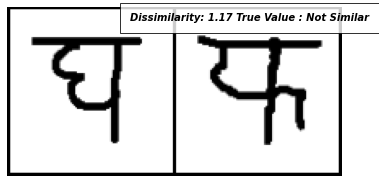

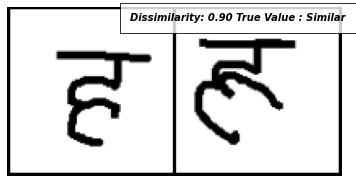

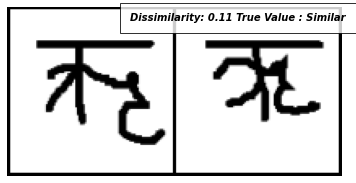

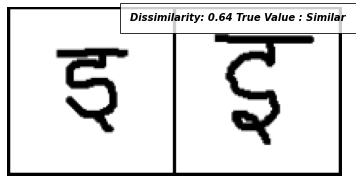

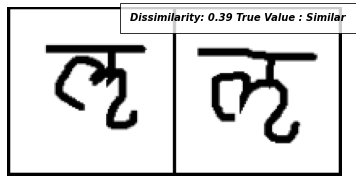

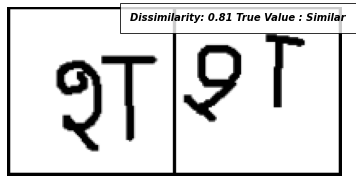

In [ ]:
testing_dataset = dsets.ImageFolder('/content/data/omniglot-py/images_background/Sanskrit')
dataset = SiameseNetworkDataset(imageFolderDataset= testing_dataset, transform = transforms.Compose([
                                                                                                 transforms.Resize((100, 100)),
                                                                                                 transforms.ToTensor()
]), should_invert = False)

test_dataloader = DataLoader(dataset= dataset, num_workers= 8, batch_size = 1 , shuffle= True)

data_iter = iter(test_dataloader)
# x0 , _ , _ = next(data_iter)
for i in range(100):
  x0, x1, label = next(data_iter)
  concatenated = torch.cat((x0, x1), 0)
  output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
  euclidean_distance = F.pairwise_distance(output1, output2)
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} True Value : {} '.format(euclidean_distance.item(), "Similar" if int(label.numpy()[0, 0]) is 0 else "Not Similar"))
